# Fine-Tuning and Clsutering Sentence Embeddings for Food Items 

In [58]:
# External package installations
!pip3 install sentence_transformers hdbscan umap-learn umap-learn[plot]

# Imports
import re
import nltk
import hdbscan
import umap.plot
import pandas                       as pd
import matplotlib.pyplot            as plt
from   nltk.corpus              import stopwords
from   nltk.tokenize            import WhitespaceTokenizer
from   nltk.stem                import WordNetLemmatizer
from   nltk.probability         import FreqDist
from   umap                     import UMAP
from   sklearn.cluster          import KMeans
from   torch.utils.data         import DataLoader
from   sklearn.metrics.cluster  import calinski_harabasz_score, silhouette_score
from   sentence_transformers    import models, datasets, losses, SentenceTransformer

# NLTK Downloads for Pre-processing
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Preprocessing

In [59]:
data_path                = '/content/drive/MyDrive/Colab Notebooks/'
df                       = pd.read_csv(f"{data_path}MenuItem.csv")

# Remove all commas from individual food items
df['Original food Item'] = df['Original food Item'].replace(',', '', regex=True)
df

,Restaurant Name,Original food Item
0,Coffee Time,Garden Vegetable Sandwich
1,HoSan,Roasted Seaweed Snack
2,Weight Watchers,Muffins
3,Natural Sea,Albacore Tuna Solid White
4,World of Beer,Caesar Salad with Grilled Flat Iron Steak
...,...,...
4519,Moxie's Classic Grill,Spring Mix Starter Salad
4520,Thundercloud Subs,Genoa Salami Low-Fat Sub Large
4521,Chick-fil-A,Cookies & Cream Milkshake Small
4522,Cereality,2% Milk


In [60]:
# Combine food items from all restaurants to create a Single Menu per row for each Restaurant
combined_df                       = df.groupby(df['Restaurant Name']).aggregate({'Original food Item': ', '.join}).reset_index()
combined_df['Original food Item'] = combined_df['Original food Item'].astype(str)
print(f'Total Restaurants = {len(combined_df)}')
combined_df.head(15)

Total Restaurants = 341


,Restaurant Name,Original food Item
0,241 Pizza,"Bacon Cheeseburger Pizza Medium Slice, Meat Lo..."
1,A&W (Canada),"Apple Juice 12 oz, Bacon & Egger on Sesame See..."
2,Amay's,Almond Cookies
3,Ameci Pizza & Pasta,"Large Ameci Deluxe Pizza, Chicken Caesar Salad..."
4,America's Taco Shop,"Jack Cheese, Carne Asada Quesadilla Regular, T..."
5,American Flatbread Grocery,"Thin & Crispy Pizza Sliced Tomato & 5 Cheese, ..."
6,Angy's,"Tri Color Cheese Tortellini, Tortellini, Torte..."
7,Arbys,Seasoned Curly Fries
8,Arcor Saic,Precooked Yellow Corn Meal
9,Back Yard Burgers,"Classic Turkey Burger, Chili Cheese Fries - La..."


Now we have a total of **341** restaurants with their entire Menu.

## Data Cleaning 

In [64]:
stop_words       = set(stopwords.words('english'))
def clean(menu):

    # Remove punctuations
    clean_menu   = re.sub(r'[^\w\s]', '', menu)
    clean_menu   = clean_menu.lower()

    # Tokenize based on Whitespaces
    words        = WhitespaceTokenizer().tokenize(clean_menu)

    # Remove stop words
    cleaned_items = [w for w in words if w not in stop_words]

    # Lemmatize words
    wnl           = WordNetLemmatizer()
    return ' '.join( [ wnl.lemmatize(token) for token in cleaned_items ] )

In [65]:
combined_df['Cleaned Items'] = combined_df['Original food Item'].apply(lambda x: clean(x))
combined_df.head()

,Restaurant Name,Original food Item,Cleaned Items
0,241 Pizza,"Bacon Cheeseburger Pizza Medium Slice, Meat Lo...",bacon cheeseburger pizza medium slice meat lov...
1,A&W (Canada),"Apple Juice 12 oz, Bacon & Egger on Sesame See...",apple juice 12 oz bacon egger sesame seed bun ...
2,Amay's,Almond Cookies,almond cooky
3,Ameci Pizza & Pasta,"Large Ameci Deluxe Pizza, Chicken Caesar Salad...",large ameci deluxe pizza chicken caesar salad ...
4,America's Taco Shop,"Jack Cheese, Carne Asada Quesadilla Regular, T...",jack cheese carne asada quesadilla regular tom...


Let's look at the frequency of words in the Restaurant Menus

[('chicken', 435), ('oz', 339), ('cheese', 248), ('pizza', 238), ('large', 221), ('cream', 208), ('chocolate', 198), ('salad', 180), ('sauce', 177), ('small', 154), ('ice', 137), ('sandwich', 122), ('rice', 122), ('milk', 114), ('smoothie', 110), ('regular', 103), ('beef', 103), ('dressing', 102), ('vanilla', 97), ('strawberry', 97)]


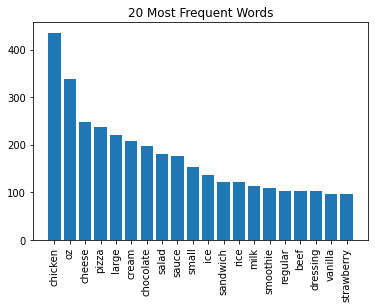

In [66]:
# Calculate Frequency Distribution
num_words          = 20
wt                 = WhitespaceTokenizer()
clean_tokens       = wt.tokenize(''.join([d for d in combined_df['Cleaned Items']]))
freq_dist          = FreqDist(clean_tokens)
common_x, common_y = [t[0] for t in freq_dist.most_common(num_words)], [t[1] for t in freq_dist.most_common(num_words)]

print(freq_dist.most_common(num_words))
plt.title(f'{num_words} Most Frequent Words')
plt.bar(common_x, common_y)
plt.xticks(rotation=90)
plt.show()

As we can see in the plot, **chicken** occurs most frequently in the corpus followed by *cheese, pizza, cream* and *choclate*

## Fine-Tune Sentence Embeddings Model

We implement a class to fine-tune a Transformer model with the an addition pooling layer the embedding layer. This enables us to extract sentence embeddings for this task.


The learning is performed in an unsupervised fashion to learn embeddings from the given food items dataset.

The class `FineTune` performs this training and returns the sentence embeddings for the given data.

In [67]:
class FineTune:

    def __init__(self, model_name, max_epochs = 2, data_path = '/content/drive/MyDrive/Colab Notebooks/'):
        self.model_name = model_name
        self.max_epochs = max_epochs
        self.data_path  = data_path
        self.dataframe  = combined_df


    def prepare_data(self):
        train_dataset    = datasets.DenoisingAutoEncoderDataset(self.dataframe['Cleaned Items'])
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        return train_dataloader


    def fine_tune(self,
                  wdecay     = 0,
                  lr         = 3e-5):

        word_embedding_model = models.Transformer(self.model_name)
        pooling_model        = models.Pooling( word_embedding_model.get_word_embedding_dimension(), 'cls' )
        model                = SentenceTransformer( modules = [ word_embedding_model, pooling_model ] )

        train_loss           = losses.DenoisingAutoEncoderLoss( model, decoder_name_or_path = self.model_name, tie_encoder_decoder=True )

        # Data prep
        sentences            = [ items for items in self.dataframe['Cleaned Items'] ]
        train_dataset        = datasets.DenoisingAutoEncoderDataset(sentences)
        train_dataloader     = DataLoader(train_dataset, batch_size=8, shuffle=True)

        model.fit(
            train_objectives   = [ ( train_dataloader, train_loss ) ],
            epochs             = self.max_epochs,
            weight_decay       = wdecay,
            scheduler          = 'constantlr',
            optimizer_params   = {'lr': lr },
            show_progress_bar  = True
        )
        return model


    def get_embeddings(self, model):
        model.eval()
        sentences = [ items for items in self.dataframe['Cleaned Items'] ]
        return model.encode( sentences, batch_size=16, show_progress_bar=True, convert_to_tensor=True )


    def visualize(self, embeddings):

        # Reduce to 2 dimensions for visualization
        umap_data        = UMAP(
         n_components    = 2,
         random_state    = 42).fit_transform(embeddings.cpu())

        # Store 2D co-ordinates in dataframe for plotting
        result           = pd.DataFrame(umap_data, columns=['x', 'y'])
        result['labels'] = self.dataframe['Restaurant Name']

        # Plot embeddings as scatter plot
        plt.title(f'Sentence Embeddings after Fine-Tuning')
        plt.scatter(result.x, result.y)
        plt.savefig(f'{self.data_path}embeddings_viz_{self.model_name}.png')
        plt.show()


    def run(self):
        # Fine-tune the model and extract embeddings
        model           = self.fine_tune()
        embeddings      = self.get_embeddings(model)
        self.visualize(embeddings)
        return embeddings

## Dimensionality Reduction

Dimensionality Reduction is performed to reduce the 784 dimensional sentence embedding vector to 50.

Uniform Manifold Approximation and Projection (UMAP) was chosen since it [claims to](https://arxiv.org/abs/1802.03426) _preserves more of the global structure with superior run time performance._ as compared to t-SNE  

In [68]:
def reduce_dims( embeddings,
                 n_components = 50,
                 n_neighbors  = 15,
                 min_dist     = 0.1,
                 metric       = 'cosine'):

    return UMAP( n_neighbors  = n_neighbors,
                 n_components = n_components,
                 min_dist     = min_dist,
                 metric       = metric,
                 random_state = 42
                ).fit_transform(embeddings)

## Clustering the Sentence Embeddings

We compare cluster outputs from two clustering methods on the 50 dimensional sentence embeddings.

### K-Means Clustering

In [69]:
def k_means_clustering(reduced_emb):
    """
    K-means clustering on the dim reduced embeddings.
    """
    return KMeans(n_clusters   = 10,
                  random_state = 42
                  ).fit(reduced_emb).labels_

### HDB Scan Clustering

In [133]:
def hdb_clustering(reduced_emb):
    """
    HDB clustering on the dim reduced embeddings.
    """
    return hdbscan.HDBSCAN(min_cluster_size         = 5,
                           min_samples              = 4,
                           metric                   = 'euclidean',
                           cluster_selection_method = 'eom'
                          ).fit(reduced_emb).labels_

### Cluster Visualization

In [71]:
def plot_clusters(reduced_emb, labels):
    mapper = UMAP( n_neighbors  = 15,
                   n_components = 2,
                   min_dist     = 0.1,
                   metric       = 'cosine',
                   random_state = 42
                   ).fit(reduced_emb)

    umap.plot.points( mapper,
                      labels = labels,
                      theme  = 'fire')
    plt.show()

## Cluster Analysis

The quantitative evaluation of the clustering done was done using two unsupervised clustering metrics:

- Silhouette score
- Calinski-Harabasz score

In [31]:
def cluster_analysis(reduced_emb, labels):
    """
    Cluster analysis on the embeddings.
    """
    plot_clusters(reduced_emb, labels)

    sil_score = silhouette_score(reduced_emb, labels)
    cal_score = calinski_harabasz_score(reduced_emb, labels)

    print(f'Silhouette score: {sil_score}')
    print(f'Calinski-Harabasz score: {cal_score}')

In [155]:
def analyse_labels(label_df, num_words = 5):
    for cluster in range(label_df.shape[0]):
        clean_tokens       = wt.tokenize(''.join([d for d in hdb_df['Cleaned Items'][cluster]]))
        freq_dist          = FreqDist(clean_tokens)
        common_x, common_y = [ t[0] for t in freq_dist.most_common(num_words) ], [ t[1] for t in freq_dist.most_common(num_words) ]

        plt.title(f'Most Frequent Words for Label {cluster+1}')
        plt.bar(common_x, common_y)
        plt.xticks(rotation=90)
        plt.show()

## Results

For the base Transformer to build the Sentence Transformer model, we use the `BERT BASE UNCASED` model. You can experiment with different models using the list [here](https://huggingface.co/models) and supply the name to the `FineTune` class. 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
When tie_encoder_decoder=True, the decoder_name_or_path will be invalid.
Some weights of the model checkpoint at bert-base-uncased were not used when initi

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/43 [00:00<?, ?it/s]

Iteration:   0%|          | 0/43 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

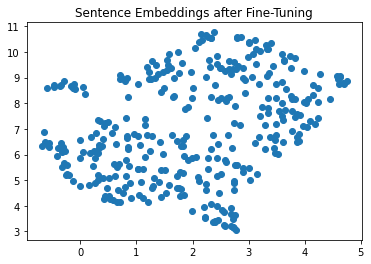

In [97]:
task       = FineTune( 'bert-base-uncased', max_epochs = 2 )
embeddings = task.run()

Examples of other transformer models
```
'bert-base-cased'
'bert-large-uncased'
'bert-large-cased'
'xlnet-base-cased'
'xlnet-large-cased'
'roberta-base'
'roberta-large'
'roberta-large-mnli'
'roberta-large-mnli-mm'
```



In [101]:
# Reduce Dimensionality for Clustering
reduced_emb = reduce_dims(embeddings.cpu(), n_components = 20)

K-Means Clustering


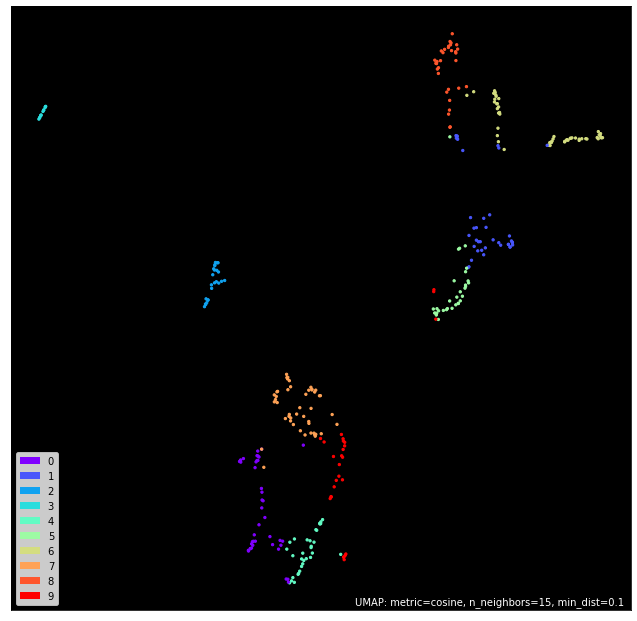

Silhouette score: 0.3659208416938782
Calinski-Harabasz score: 391.9122885061257


In [102]:
# K-Means Clustering
print(f'K-Means Clustering')
kmeans_labels = k_means_clustering(reduced_emb)
cluster_analysis(reduced_emb, kmeans_labels)

HDB Scan Clustering


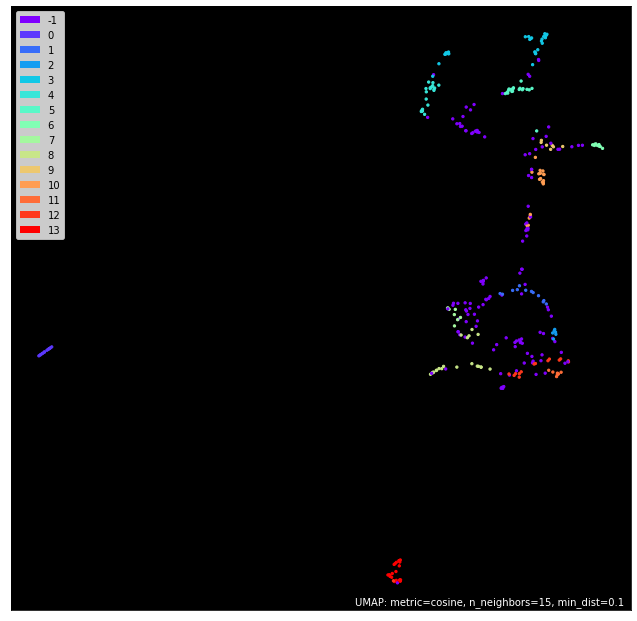

Silhouette score: 0.06848572194576263
Calinski-Harabasz score: 65.16148660598063


In [127]:
# HDB Scan Clustering
print(f'HDB Scan Clustering')
reduced_emb  = reduce_dims(embeddings.cpu(), n_components = 30)
hdb_labels   = hdb_clustering(reduced_emb)
cluster_analysis(reduced_emb, hdb_labels)

### Comparison of Index Scores

We reduce the dimensionality to **30** for HDB Scan Clustering. The Silhouette Score is **significantly lower** than that of K-Means. 
Also, the Variance Ratio Criterion index is lower denoting poor clustering of the embeddings.

### Analyse Labels

We can group the menu items for restaurants from the same cluster and calculate the frequency distribution. This will help us analyse the semantic relationship within the cluster.

In [132]:
combined_df['HDB Labels']     = hdb_labels
combined_df['K Means Labels'] = kmeans_labels
combined_df

,Restaurant Name,Original food Item,Cleaned Items,HDB Labels,K Means Labels
0,241 Pizza,"Bacon Cheeseburger Pizza Medium Slice, Meat Lo...",bacon cheeseburger pizza medium slice meat lov...,3,6
1,A&W (Canada),"Apple Juice 12 oz, Bacon & Egger on Sesame See...",apple juice 12 oz bacon egger sesame seed bun ...,3,6
2,Amay's,Almond Cookies,almond cooky,12,7
3,Ameci Pizza & Pasta,"Large Ameci Deluxe Pizza, Chicken Caesar Salad...",large ameci deluxe pizza chicken caesar salad ...,4,8
4,America's Taco Shop,"Jack Cheese, Carne Asada Quesadilla Regular, T...",jack cheese carne asada quesadilla regular tom...,3,6
...,...,...,...,...,...
336,Yellow Tail,"Moscato, Pinot Grigio",moscato pinot grigio,13,2
337,YoCream,"Plain, Very Strawberry, Pistachio Gelato, Silk...",plain strawberry pistachio gelato silk almondm...,10,5
338,Yogli Mogli,"Carrot Cake, Pumpkin, Cookies N Cream, Mango T...",carrot cake pumpkin cooky n cream mango tango ...,10,5
339,Yoshinoya,"No Calorie Brisk Green Tea with Peach, Grilled...",calorie brisk green tea peach grilled steak ki...,3,6


In [156]:
hdb_df = combined_df.sort_values('HDB Labels')
hdb_df = hdb_df.groupby(hdb_df['HDB Labels']).aggregate({'Cleaned Items': ', '.join}).reset_index()
hdb_df

,HDB Labels,Cleaned Items
0,-1,"refried bean spicy dried beef, parmesan caesar..."
1,0,shrimp calamari ring crab cheese bite stuffed ...
2,1,100 grated parmesan cheese bread crumb plain g...
3,2,"cranberry nut mix, dark chocolate pear cinnamo..."
4,3,margherita calzone t garden veggie pizza famil...
5,4,extra meaty baby back pork rib sweet smoky bab...
6,5,powerup fresh fruit yogurt cup americano small...
7,6,planet pro veg 32g strawberry acai smoothie 32...
8,7,sliced bamboo shoot baby corn small whole cock...
9,8,"raisin, steak mushroom cheddar flatbread melt,..."


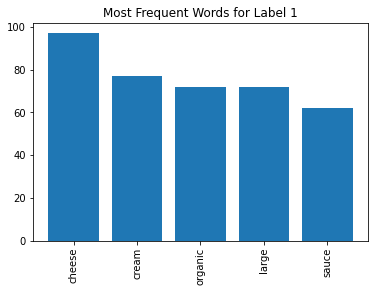

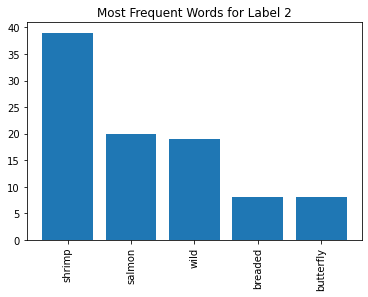

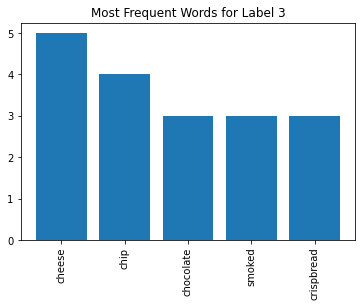

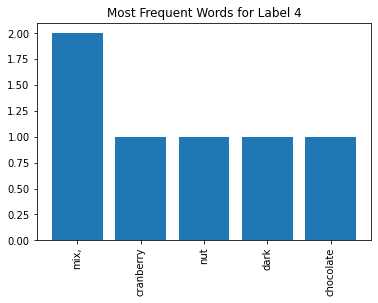

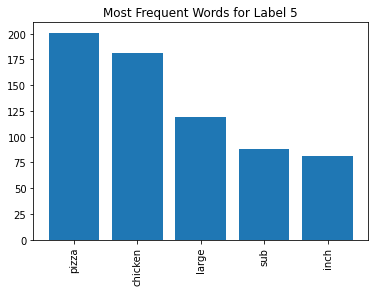

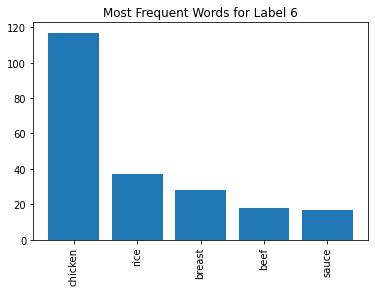

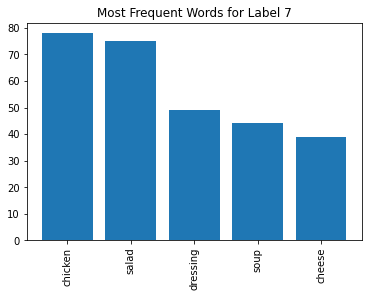

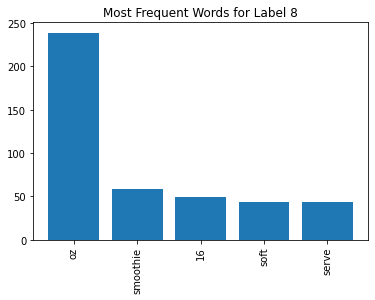

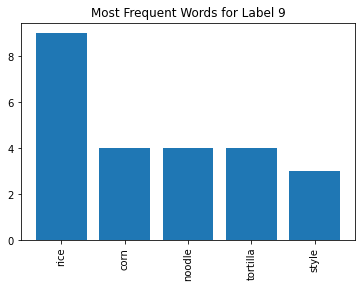

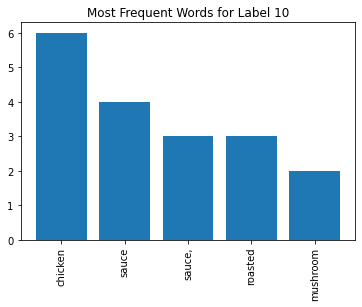

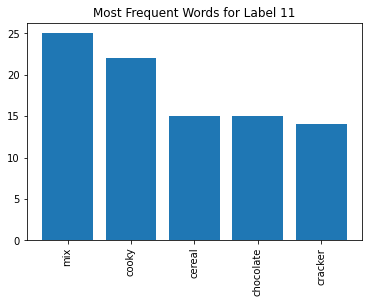

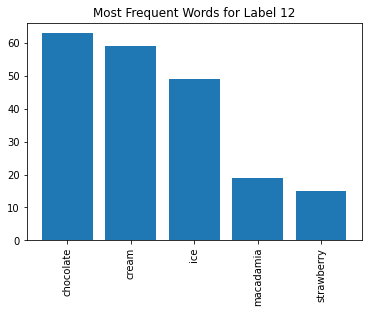

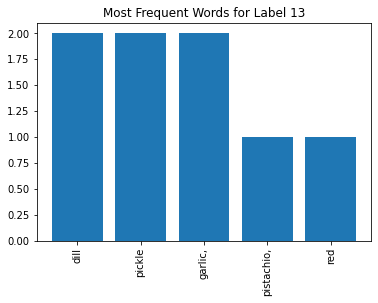

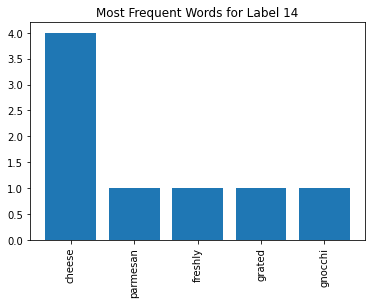

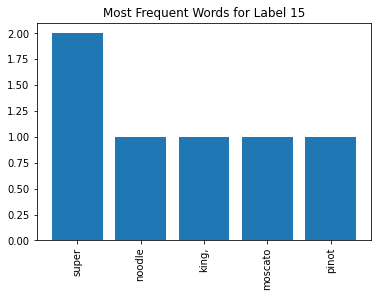

In [154]:
analyse_labels(hdb_df)

In [158]:
kmeans_df = combined_df.sort_values('K Means Labels')
kmeans_df = kmeans_df.groupby(kmeans_df['K Means Labels']).aggregate({'Cleaned Items': ', '.join}).reset_index()
kmeans_df

,K Means Labels,Cleaned Items
0,0,"refried bean spicy dried beef, peanut salted s..."
1,1,bagel blueberry bagel cream cheese bagel egg c...
2,2,"creme brulee, original snappy beer cheese, toc..."
3,3,teriyaki salmon burger wild alaskan pink salmo...
4,4,cheese tortellini stuffed shell ricotta cavate...
5,5,hard candy butterscotch rich chocolate cookie ...
6,6,junior jax pork rice bowl kid mandarin orange ...
7,7,"pecan praline, blueberry pomegranate chia dres..."
8,8,steak tip natural ranch steak natural cube ste...
9,9,bagel dog polish sausage straw smoked chorizo ...


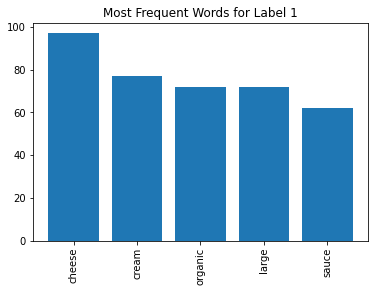

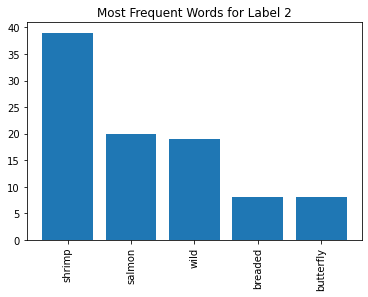

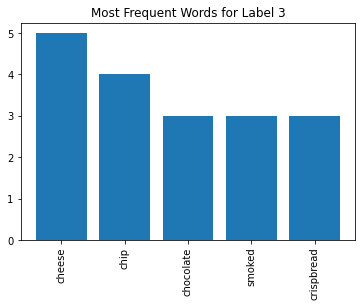

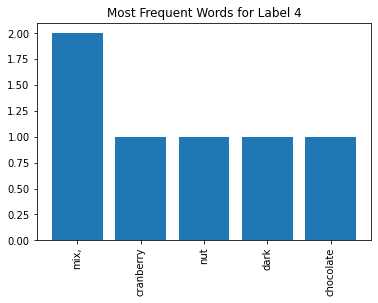

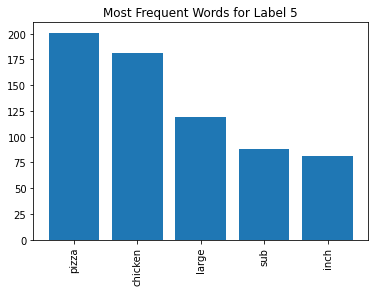

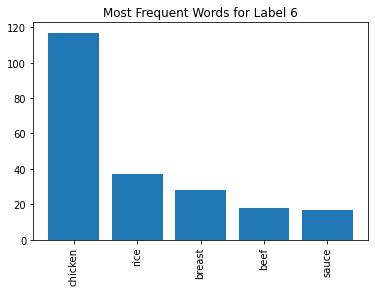

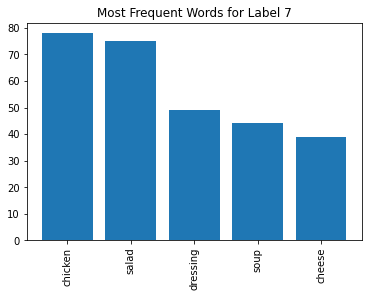

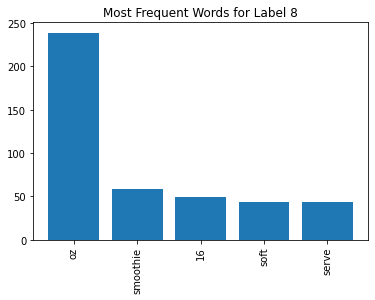

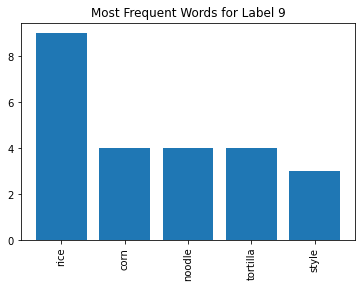

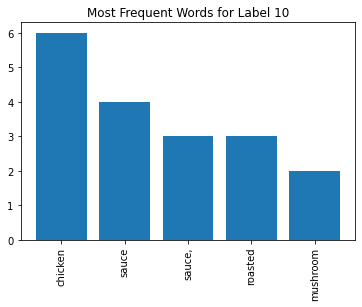

In [159]:
analyse_labels(kmeans_df)

### Group Restaurants from same clusters

In [165]:
grouped = combined_df.sort_values('K Means Labels')
grouped = grouped.groupby( grouped['K Means Labels'] ).aggregate( { 'Restaurant Name': ', '.join } ).reset_index()
grouped.T

,0,1,2,3,4,5,6,7,8,9
K Means Labels,0,1,2,3,4,5,6,7,8,9
Restaurant Name,"Zapata, Texas Roadhouse, Martel, Marie Callend...","Duck Donuts, Harris Teeter, Cracker Barrel, Du...","Emeril, Hall's, PFC, Paone, Henny's, Frey's, Y...","Henry & Lisa's, Rushing Waters, Mrs. Friday's,...","Rizzo's, Maninis, Ivar's, Tom and Chee, Delmon...","Mandy's, Maizena, Capri Sun, Gail Ambrosius, M...","Pepperjax Grill, Roy Rogers Restaurants, Silve...","Nanny's, Organic Drew's, Molina, Emily Kate's,...","Tender Bison, Tom's, Tubby's, Tyson, Triple O'...","Benny's, Burger King, Whitey's Ice Cream, Wild..."


## Final Thoughts

For the given set of paramters, K-Means clustering seemingly outperforms HDB Scan clustering for the given dataset.

However, there is plenty of hyper-parameter tuning for the dimensions and clustering parameters that can be done for the `bert-base-uncased` and other listed models.


This notebook present reproducible code for quick experimentation and hyper-parameter tuning with the `MenuItems.csv` dataset.